# Order Delivery Time Prediction

## Objectives
The objective of this assignment is to build a regression model that predicts the delivery time for orders placed through Porter. The model will use various features such as the items ordered, the restaurant location, the order protocol, and the availability of delivery partners.

The key goals are:
- Predict the delivery time for an order based on multiple input features
- Improve delivery time predictions to optimiae operational efficiency
- Understand the key factors influencing delivery time to enhance the model's accuracy

## Data Pipeline
The data pipeline for this assignment will involve the following steps:
1. **Data Loading**
2. **Data Preprocessing and Feature Engineering**
3. **Exploratory Data Analysis**
4. **Model Building**
5. **Model Inference**

## Data Understanding
The dataset contains information on orders placed through Porter, with the following columns:

| Field                     | Description                                                                                 |
|---------------------------|---------------------------------------------------------------------------------------------|
| market_id                 | Integer ID representing the market where the restaurant is located.                         |
| created_at                | Timestamp when the order was placed.                                                        |
| actual_delivery_time      | Timestamp when the order was delivered.                                                     |
| store_primary_category    | Category of the restaurant (e.g., fast food, dine-in).                                      |
| order_protocol            | Integer representing how the order was placed (e.g., via Porter, call to restaurant, etc.). |
| total_items               | Total number of items in the order.                                                         |
| subtotal                  | Final price of the order.                                                                   |
| num_distinct_items        | Number of distinct items in the order.                                                      |
| min_item_price            | Price of the cheapest item in the order.                                                    |
| max_item_price            | Price of the most expensive item in the order.                                              |
| total_onshift_dashers     | Number of delivery partners on duty when the order was placed.                              |
| total_busy_dashers        | Number of delivery partners already occupied with other orders.                             |
| total_outstanding_orders  | Number of orders pending fulfillment at the time of the order.                              |
| distance                  | Total distance from the restaurant to the customer.                                         |


## **Importing Necessary Libraries**

In [96]:
# Import essential libraries for data manipulation and analysis

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## **1. Loading the data**
Load 'porter_data_1.csv' as a DataFrame

In [16]:
# Importing the file porter_data_1.csv
import pandas as pd
df = pd.read_csv("porter_data_1.csv")
print (df.head())

   market_id           created_at actual_delivery_time  \
0        1.0  2015-02-06 22:24:17  2015-02-06 23:11:17   
1        2.0  2015-02-10 21:49:25  2015-02-10 22:33:25   
2        2.0  2015-02-16 00:11:35  2015-02-16 01:06:35   
3        1.0  2015-02-12 03:36:46  2015-02-12 04:35:46   
4        1.0  2015-01-27 02:12:36  2015-01-27 02:58:36   

   store_primary_category  order_protocol  total_items  subtotal  \
0                       4             1.0            4      3441   
1                      46             2.0            1      1900   
2                      36             3.0            4      4771   
3                      38             1.0            1      1525   
4                      38             1.0            2      3620   

   num_distinct_items  min_item_price  max_item_price  total_onshift_dashers  \
0                   4             557            1239                   33.0   
1                   1            1400            1400                    1.0   
2 

## **2. Data Preprocessing and Feature Engineering** <font color = red>[15 marks]</font> <br>

#### **2.1 Fixing the Datatypes**  <font color = red>[5 marks]</font> <br>
The current timestamps are in object format and need conversion to datetime format for easier handling and intended functionality

##### **2.1.1** <font color = red>[2 marks]</font> <br>
Convert date and time fields to appropriate data type

In [20]:
# Convert 'created_at' and 'actual_delivery_time' columns to datetime format
df['created_at'] = pd.to_datetime(df['created_at'])
df ['actual_delivery_time'] = pd.to_datetime(df['actual_delivery_time'])
print (df[['created_at','actual_delivery_time']].head())

           created_at actual_delivery_time
0 2015-02-06 22:24:17  2015-02-06 23:11:17
1 2015-02-10 21:49:25  2015-02-10 22:33:25
2 2015-02-16 00:11:35  2015-02-16 01:06:35
3 2015-02-12 03:36:46  2015-02-12 04:35:46
4 2015-01-27 02:12:36  2015-01-27 02:58:36


##### **2.1.2**  <font color = red>[3 marks]</font> <br>
Convert categorical fields to appropriate data type

In [28]:
# Convert categorical features to category type

for col in df.columns:
    if df[col].dtype == 'object' and df [col].nunique() < 100:
        df [col] = df [col].astype('category')
        print(f"{col}: {df[col].nunique()} unique values")

#### **2.2 Feature Engineering** <font color = red>[5 marks]</font> <br>
Calculate the time taken to execute the delivery as well as extract the hour and day at which the order was placed

##### **2.2.1** <font color = red>[2 marks]</font> <br>
Calculate the time taken using the features `actual_delivery_time` and `created_at`

In [33]:
# Calculate time taken in minutes
df ["time_taken_min"] = (df ['actual_delivery_time'] - df['created_at']).dt.total_seconds() / 60
print(df[['created_at', 'actual_delivery_time','time_taken_min']].head())

           created_at actual_delivery_time  time_taken_min
0 2015-02-06 22:24:17  2015-02-06 23:11:17            47.0
1 2015-02-10 21:49:25  2015-02-10 22:33:25            44.0
2 2015-02-16 00:11:35  2015-02-16 01:06:35            55.0
3 2015-02-12 03:36:46  2015-02-12 04:35:46            59.0
4 2015-01-27 02:12:36  2015-01-27 02:58:36            46.0


##### **2.2.2** <font color = red>[3 marks]</font> <br>
Extract the hour at which the order was placed and which day of the week it was. Drop the unnecessary columns.

In [41]:
# Extract the hour and day of week from the 'created_at' timestamp
df ['order_hour'] = df['created_at'].dt.hour
df ['order_day'] = df['created_at'].dt.day_name()
# Create a categorical feature 'isWeekend'
df ['isWeekend'] = df['order_day'].isin(['Saturday','Sunday'])
print(df[['order_hour', 'order_day', 'isWeekend']].head())

   order_hour order_day  isWeekend
0          22    Friday      False
1          21   Tuesday      False
2           0    Monday      False
3           3  Thursday      False
4           2   Tuesday      False


In [51]:
# Drop unnecessary columns
cols_to_drop = ['created_at', 'actual_delivery_time']
df.drop(columns=[col for col in cols_to_drop if col in df.columns], inplace = True)
print(df.head())

   market_id  store_primary_category  order_protocol  total_items  subtotal  \
0        1.0                       4             1.0            4      3441   
1        2.0                      46             2.0            1      1900   
2        2.0                      36             3.0            4      4771   
3        1.0                      38             1.0            1      1525   
4        1.0                      38             1.0            2      3620   

   num_distinct_items  min_item_price  max_item_price  total_onshift_dashers  \
0                   4             557            1239                   33.0   
1                   1            1400            1400                    1.0   
2                   3             820            1604                    8.0   
3                   1            1525            1525                    5.0   
4                   2            1425            2195                    5.0   

   total_busy_dashers  total_outstanding_ord

#### **2.3 Creating training and validation sets** <font color = red>[5 marks]</font> <br>

##### **2.3.1** <font color = red>[2 marks]</font> <br>
 Define target and input features

In [58]:
# Define target variable (y) and features (X)
y = df['time_taken_min']
x = df.drop(['time_taken_min'],axis = 1)
print("x Shape:" ,x.shape)
print("y Shape:", y.shape)

x Shape: (175777, 16)
y Shape: (175777,)


##### **2.3.2** <font color = red>[3 marks]</font> <br>
 Split the data into training and test sets

In [68]:
# Split data into training and testing sets
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=42)
print("Train shape:", x_train.shape)
print("Test shape:", x_test.shape)

Train shape: (140621, 16)
Test shape: (35156, 16)


## **3. Exploratory Data Analysis on Training Data** <font color = red>[20 marks]</font> <br>
1. Analyzing the correlation between variables to identify patterns and relationships
2. Identifying and addressing outliers to ensure the integrity of the analysis
3. Exploring the relationships between variables and examining the distribution of the data for better insights

#### **3.1 Feature Distributions** <font color = red> [7 marks]</font> <br>


In [74]:
# Define numerical and categorical columns for easy EDA and data manipulation
num_cols = x_train.select_dtypes(include=['int64','float64']).columns.to_list()
cat_cols = x_train.select_dtypes(include=['object','category','bool']).columns.to_list()
print("Numeric Columns:" ,num_cols)
print("Categorical Columns:" ,cat_cols)

Numeric Columns: ['market_id', 'store_primary_category', 'order_protocol', 'total_items', 'subtotal', 'num_distinct_items', 'min_item_price', 'max_item_price', 'total_onshift_dashers', 'total_busy_dashers', 'total_outstanding_orders', 'distance', 'time_taken_minutes']
Categorical Columns: ['order_day', 'isWeekend']


##### **3.1.1** <font color = red>[3 marks]</font> <br>
Plot distributions for numerical columns in the training set to understand their spread and any skewness

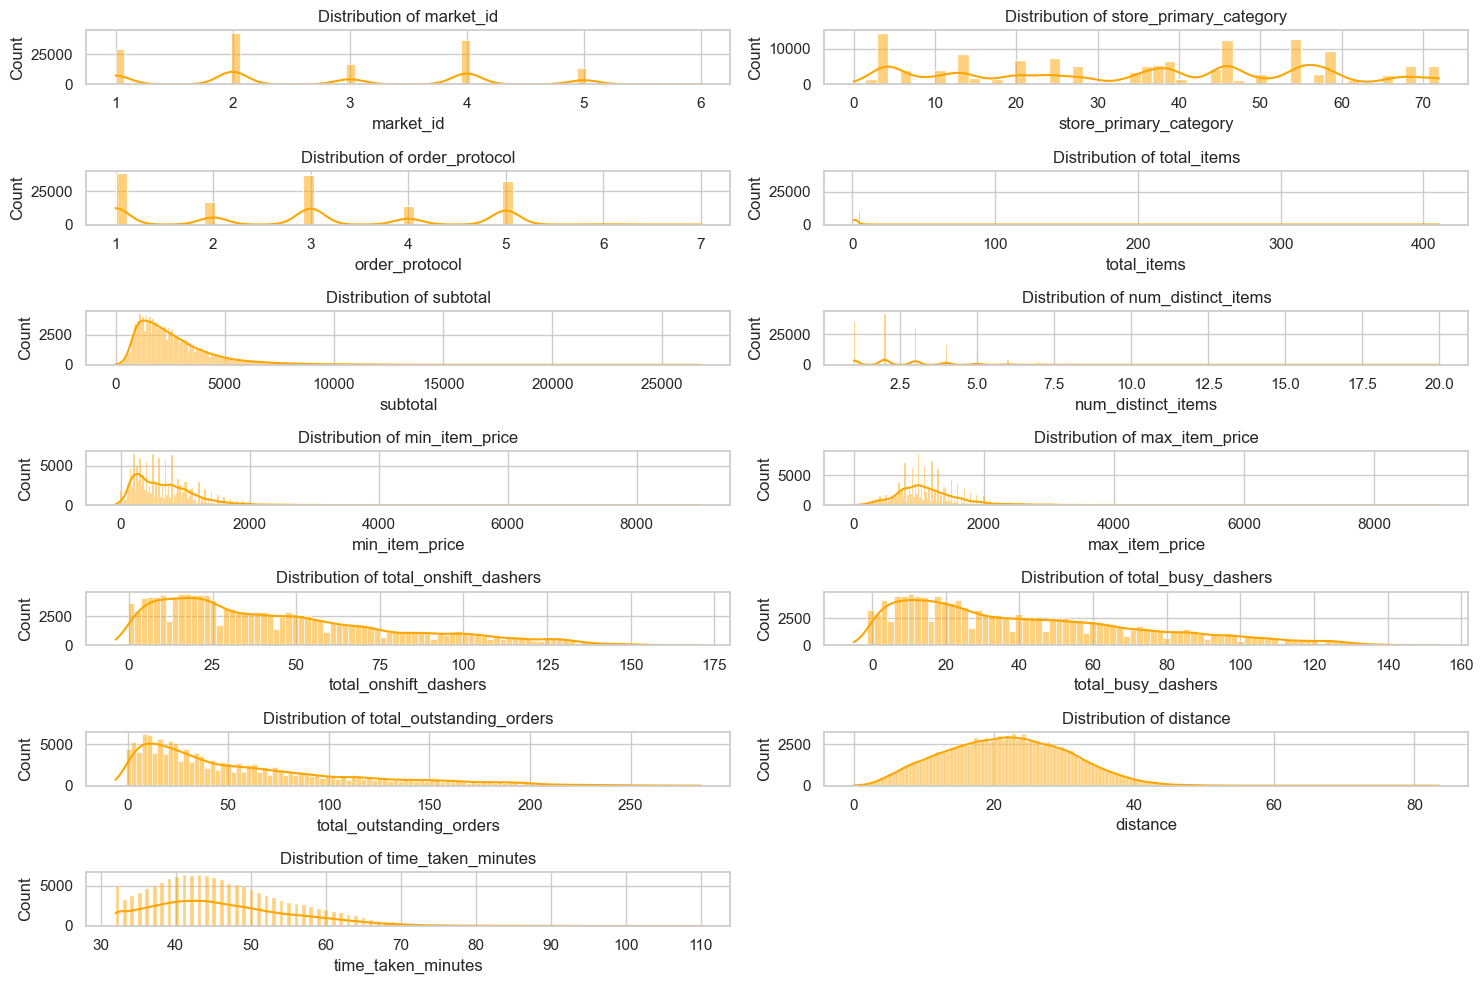

In [91]:
# Plot distributions for all numerical columns
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style='whitegrid')
plt.figure(figsize=(15,10))
for i, col in enumerate(num_cols):
    plt.subplot(len(num_cols) // 2+1,2,i+1)
    sns.histplot(x_train[col],kde=True,color='orange')
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.tight_layout()
plt.show()

##### **3.1.2** <font color = red>[2 marks]</font> <br>
Check the distribution of categorical features

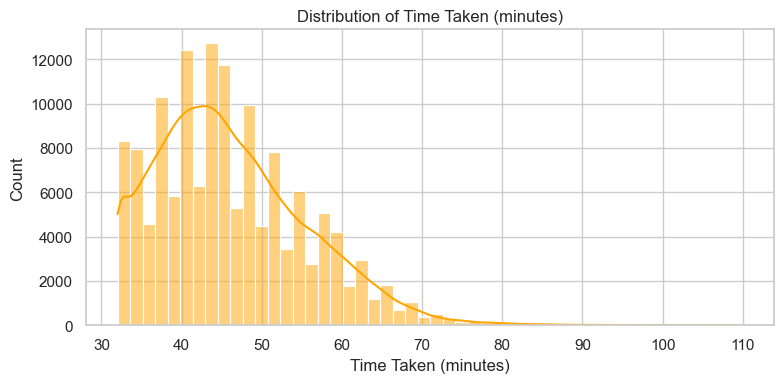

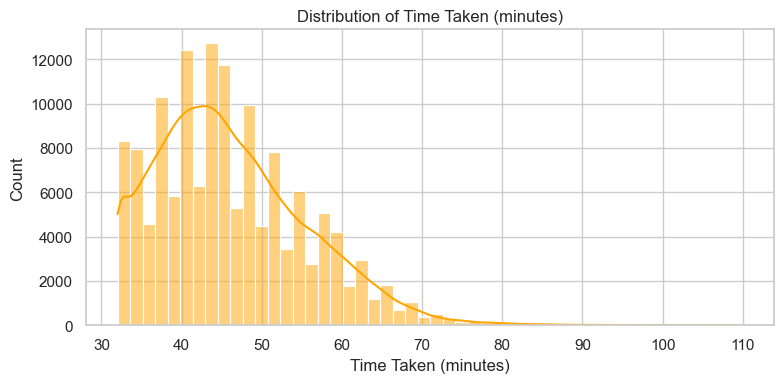

In [102]:
# Distribution of categorical columns

for cal in cat_cols:
    plt.figure(figsize=(8, 4))
    sns.histplot(x_train['time_taken_minutes'], kde=True, bins=50, color='orange')
    plt.title('Distribution of Time Taken (minutes)')
    plt.xlabel('Time Taken (minutes)')
    plt.ylabel('Count')
    plt.tight_layout()
    plt.show()

##### **3.1.3** <font color = red>[2 mark]</font> <br>
Visualise the distribution of the target variable to understand its spread and any skewness

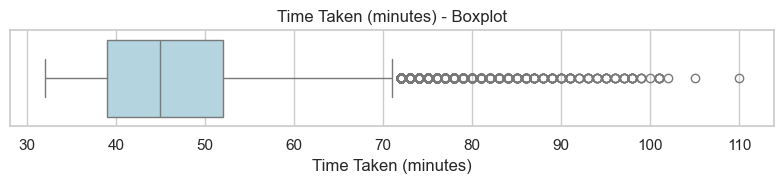

In [104]:
# Distribution of time_taken

plt.figure(figsize=(8, 2))
sns.boxplot(x=y_train, color='lightblue')
plt.title("Time Taken (minutes) - Boxplot")
plt.xlabel("Time Taken (minutes)")
plt.tight_layout()
plt.show()

#### **3.2 Relationships Between Features** <font color = red>[3 marks]</font> <br>

##### **3.2.1** <font color = red>[3 marks]</font> <br>
Scatter plots for important numerical and categorical features to observe how they relate to `time_taken`

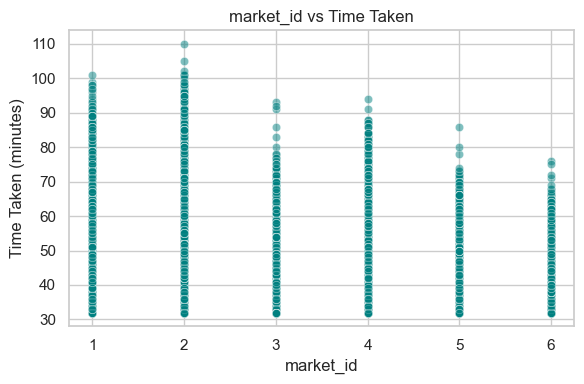

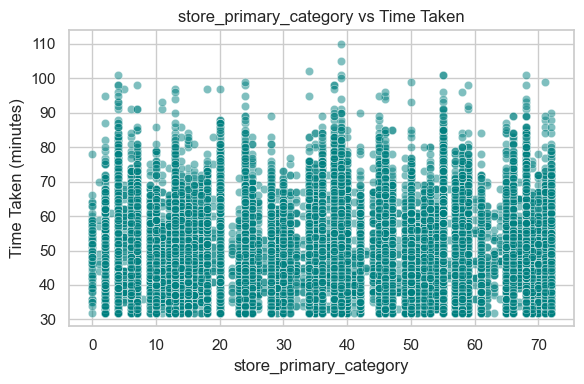

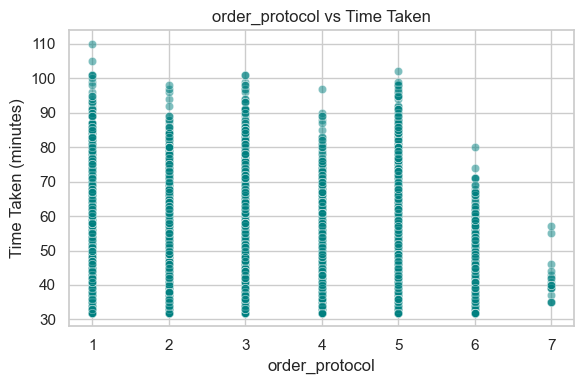

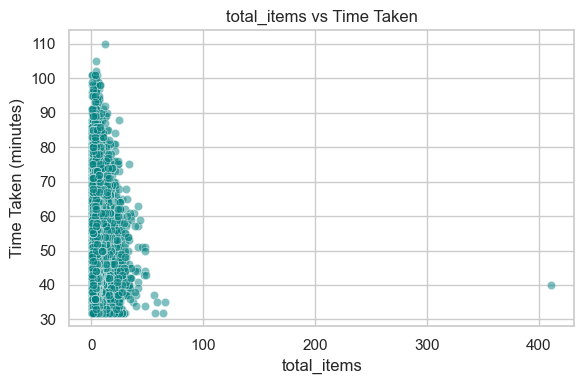

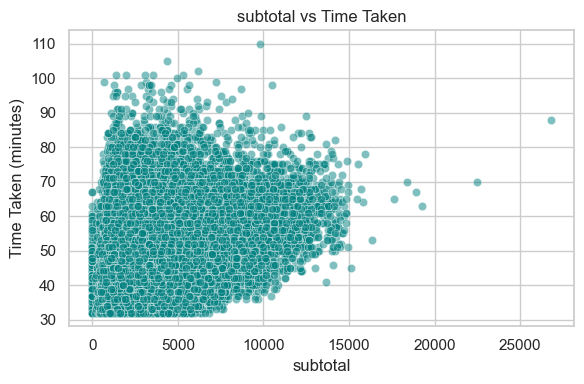

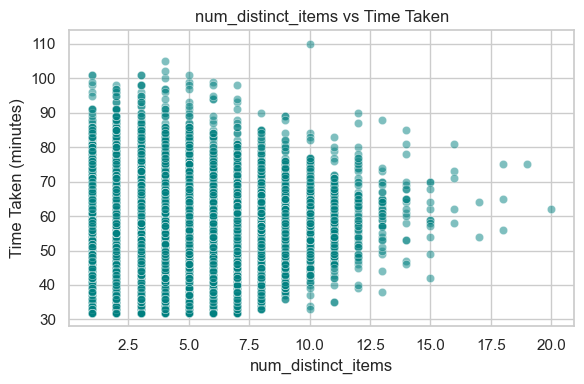

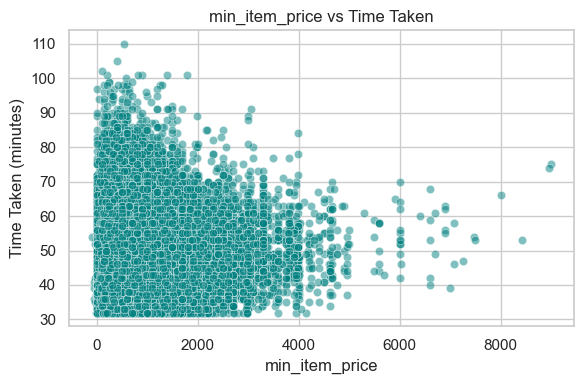

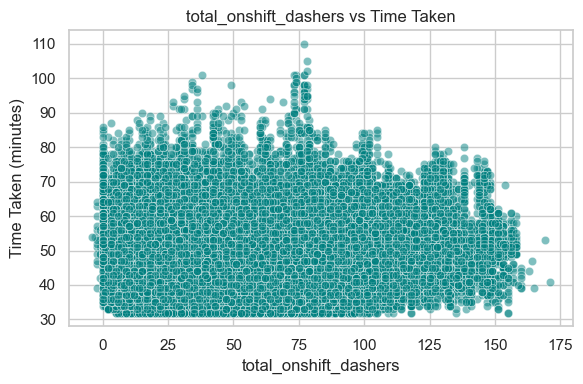

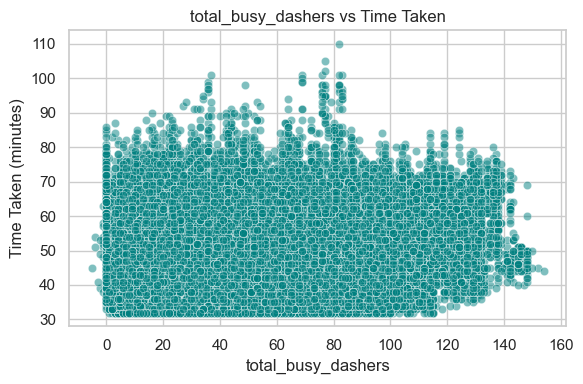

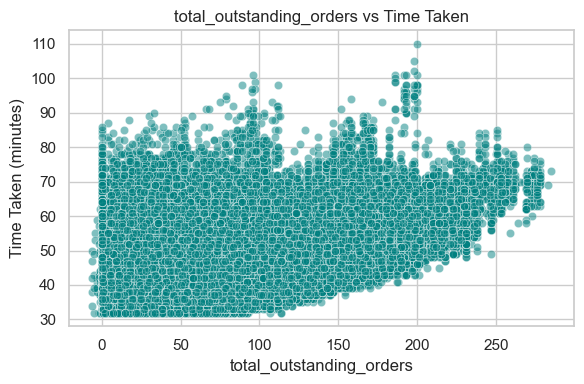

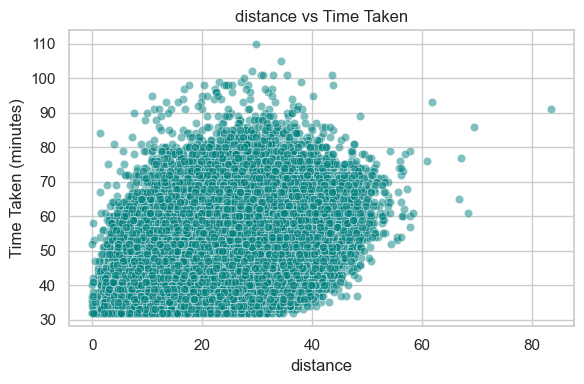

In [106]:
# Scatter plot to visualise the relationship between time_taken and other features
for col in num_cols:
    if col != 'time_taken_minutes':  # Avoid plotting y vs y
        plt.figure(figsize=(6, 4))
        sns.scatterplot(x=x_train[col], y=y_train, alpha=0.5, color='teal')
        plt.title(f'{col} vs Time Taken')
        plt.xlabel(col)
        plt.ylabel('Time Taken (minutes)')
        plt.tight_layout()
        plt.show()

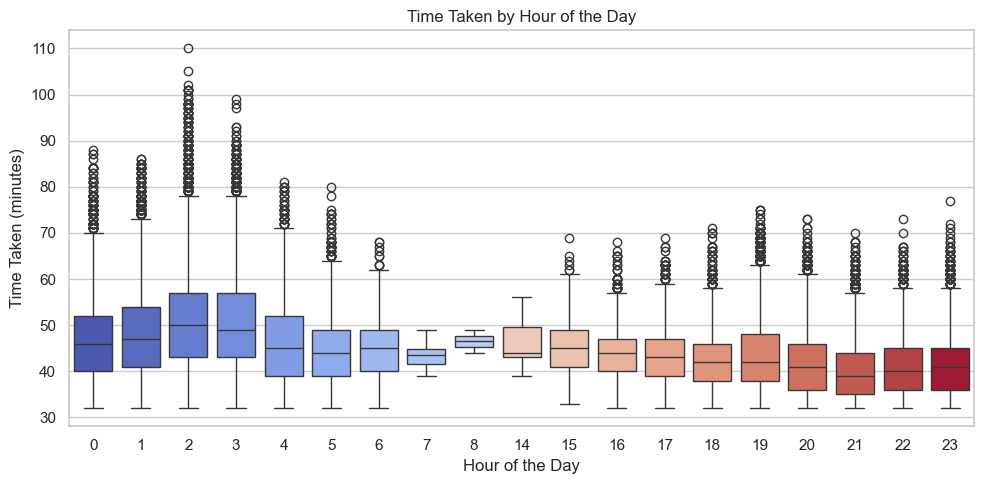

In [110]:
# Show the distribution of time_taken for different hours
plt.figure(figsize=(10, 5))
sns.boxplot(x=x_train['order_hour'], y=y_train, hue=x_train['order_hour'], palette='coolwarm', legend=False)

plt.title('Time Taken by Hour of the Day')
plt.xlabel('Hour of the Day')
plt.ylabel('Time Taken (minutes)')
plt.tight_layout()
plt.show()

#### **3.3 Correlation Analysis** <font color = red>[5 marks]</font> <br>
Check correlations between numerical features to identify which variables are strongly related to `time_taken`

##### **3.3.1** <font color = red>[3 marks]</font> <br>
Plot a heatmap to display correlations

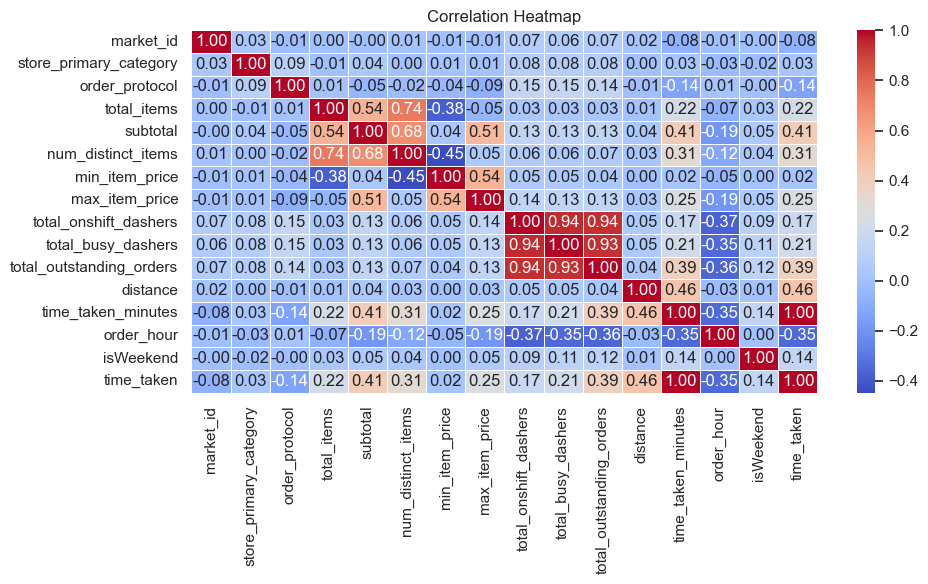

In [112]:
corr_df = x_train.copy()
corr_df['time_taken'] = y_train
corr_matrix = corr_df.corr(numeric_only=True)

plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)

plt.title('Correlation Heatmap')
plt.tight_layout()
plt.show()

##### **3.3.2** <font color = red>[2 marks]</font> <br>
Drop the columns with weak correlations with the target variable

In [114]:
# Drop 3-5 weakly correlated columns from training dataset

correlations = x_train.corr(numeric_only=True).apply(lambda col: y_train.corr(col))

weak_features = correlations[correlations.abs() < 0.05].index.tolist()

print("Dropping these weakly correlated columns:", weak_features)

x_train.drop(columns=weak_features, inplace=True)
x_test.drop(columns=weak_features, inplace=True)


Dropping these weakly correlated columns: []


#### **3.4 Handling the Outliers** <font color = red>[5 marks]</font> <br>



##### **3.4.1** <font color = red>[2 marks]</font> <br>
Visualise potential outliers for the target variable and other numerical features using boxplots

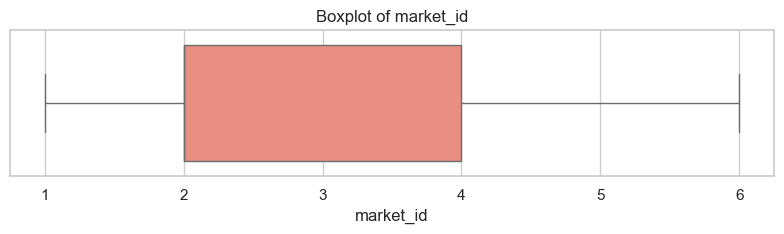

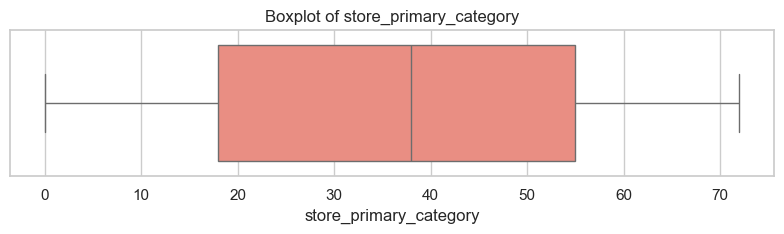

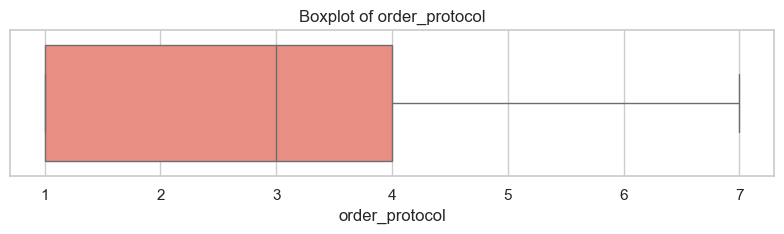

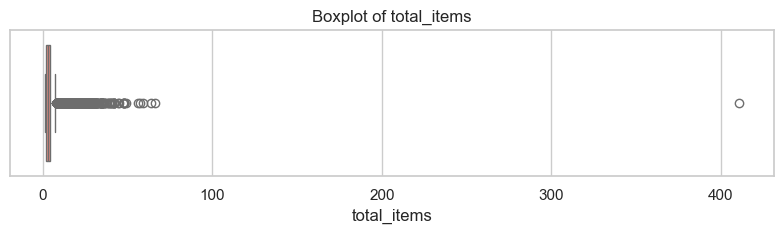

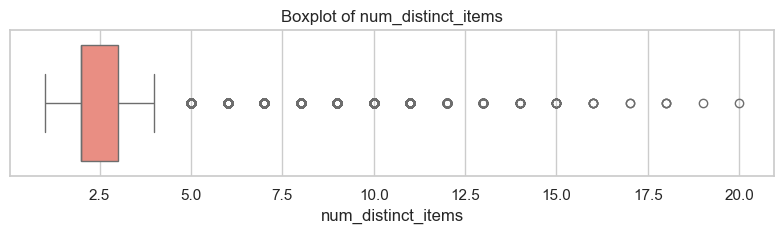

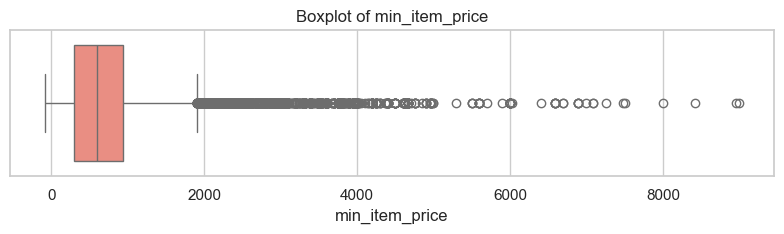

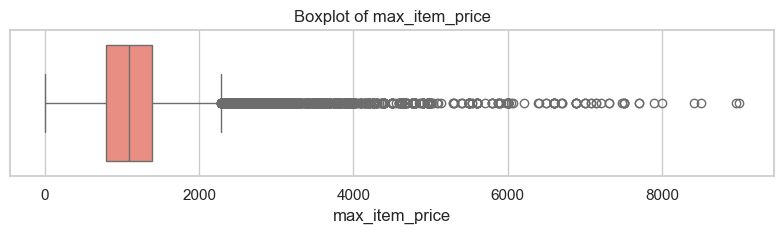

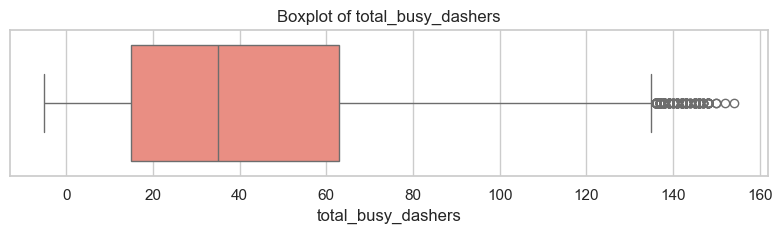

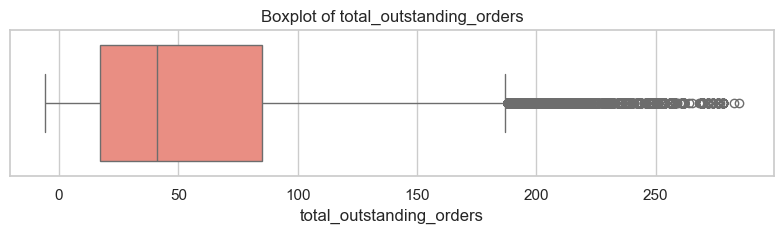

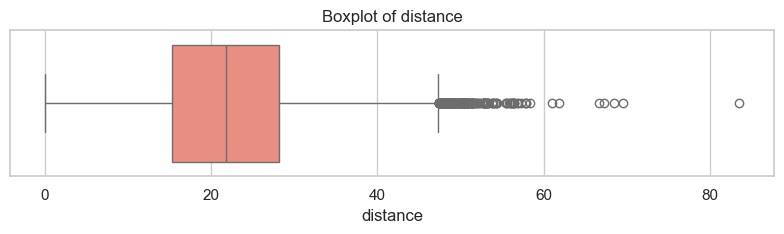

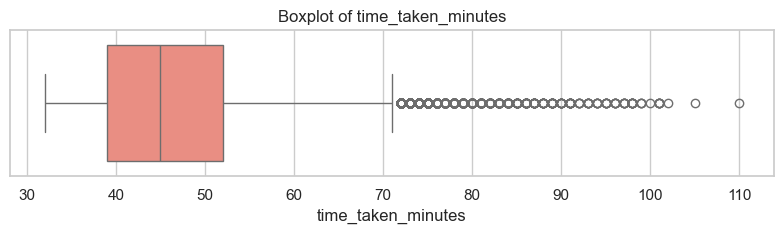

In [117]:
# Boxplot for time_taken

boxplot_data = x_train.copy()
boxplot_data['time_taken'] = y_train

for col in boxplot_data.select_dtypes(include=['int64', 'float64']).columns:
    plt.figure(figsize=(8, 2.5))
    sns.boxplot(x=boxplot_data[col], color='salmon')
    plt.title(f"Boxplot of {col}")
    plt.xlabel(col)
    plt.tight_layout()
    plt.show()

##### **3.4.2** <font color = red>[3 marks]</font> <br>
Handle outliers present in all columns

In [124]:
# Handle outliers

data = x_train.copy()
data['time_taken'] = y_train

for col in data.select_dtypes(include='number'):
    q1, q3 = data[col].quantile([0.25, 0.75])
    iqr = q3 - q1
    data[col] = data[col].clip(q1 - 1.5 * iqr, q3 + 1.5 * iqr)

x_train = data.drop('time_taken', axis=1)
y_train = data['time_taken']

print(x_train.head())
print(y_train.head())

sns.boxplot(x=y_train, color='lightblue')
plt.title("Time Taken (After Removing Outliers)")
plt.show()


        market_id  store_primary_category  order_protocol  total_items  \
102712        2.0                      45             2.0            1   
94576         4.0                      20             3.0            1   
49784         1.0                      36             3.0            4   
37753         3.0                      39             1.0            2   
91728         2.0                       6             1.0            1   

        subtotal  num_distinct_items  min_item_price  max_item_price  \
102712     820.0                 1.0           745.0             745   
94576      995.0                 1.0           995.0             995   
49784     2040.0                 4.0           150.0             895   
37753     2376.0                 2.0           579.0            1399   
91728     1430.0                 1.0          1320.0            1320   

        total_onshift_dashers  total_busy_dashers  total_outstanding_orders  \
102712                   35.0              

## **4. Exploratory Data Analysis on Validation Data** <font color = red>[optional]</font> <br>
Optionally, perform EDA on test data to see if the distribution match with the training data

In [126]:
# Define numerical and categorical columns for easy EDA and data manipulation

num_cols = [col for col in x_train.columns if x_train[col].dtype in ['int64', 'float64']]

cat_cols = [col for col in x_train.columns if x_train[col].dtype in ['object', 'category', 'bool']]
print("Numeric columns:", num_cols)
print("Categorical columns:", cat_cols)


Numeric columns: ['market_id', 'store_primary_category', 'order_protocol', 'total_items', 'subtotal', 'num_distinct_items', 'min_item_price', 'max_item_price', 'total_onshift_dashers', 'total_busy_dashers', 'total_outstanding_orders', 'distance', 'time_taken_minutes']
Categorical columns: ['order_day', 'isWeekend']


#### **4.1 Feature Distributions**


##### **4.1.1**
Plot distributions for numerical columns in the validation set to understand their spread and any skewness

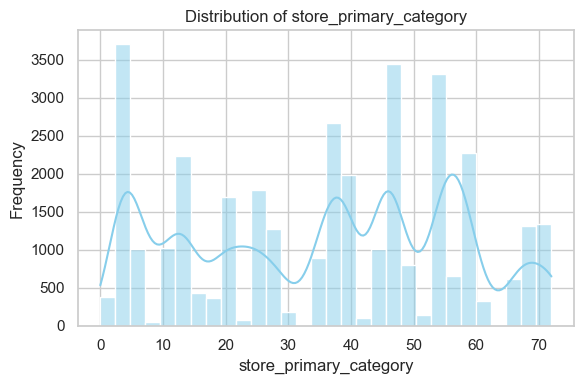

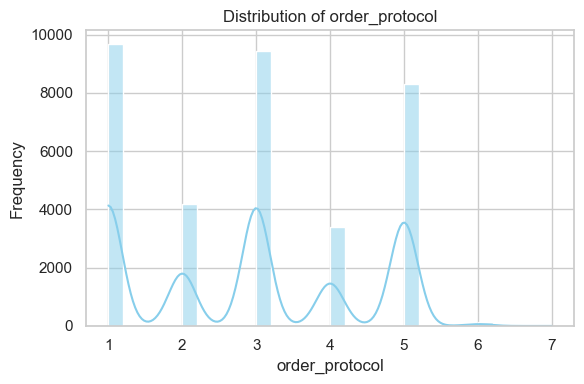

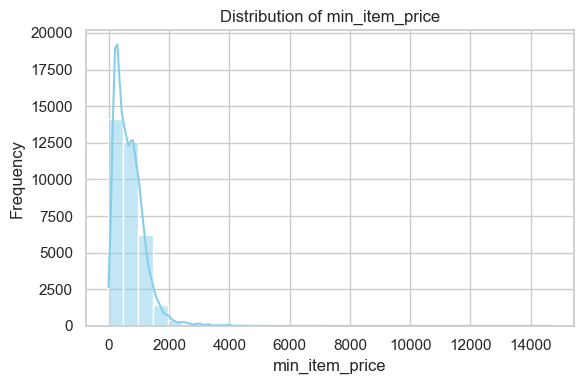

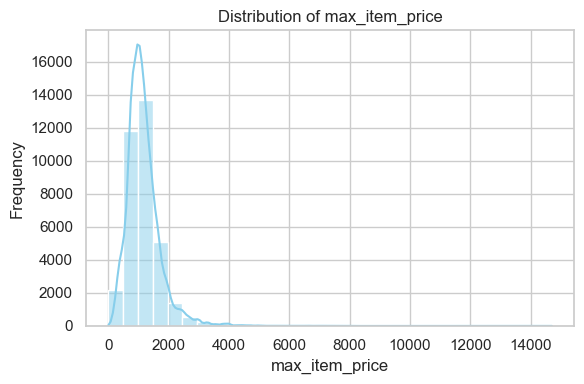

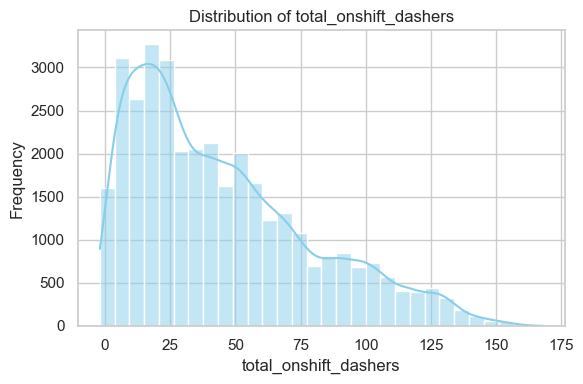

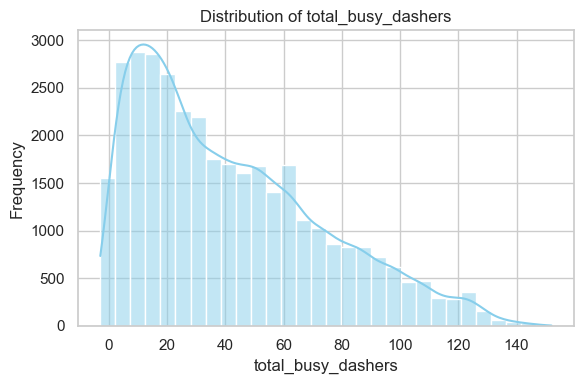

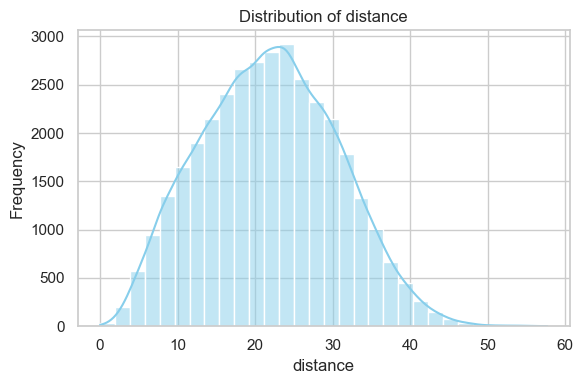

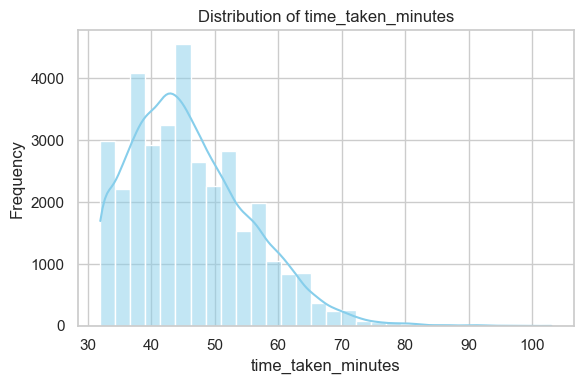

In [128]:
# Plot distributions for all numerical columns
for col in x_test.select_dtypes(include=['int64', 'float64']).columns:
    plt.figure(figsize=(6, 4))
    sns.histplot(x_test[col], kde=True, bins=30, color='skyblue')
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()

##### **4.1.2**
Check the distribution of categorical features

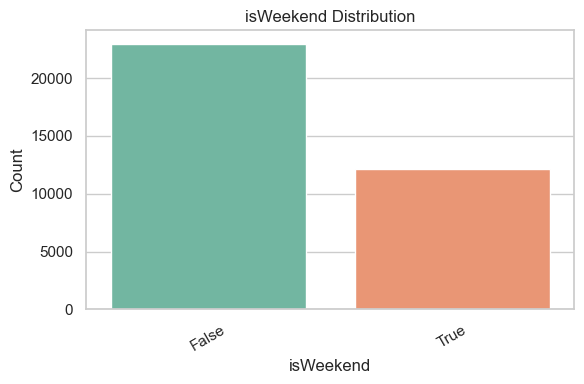

In [132]:
# Distribution of categorical columns
for col in cat_cols:
    if col in x_test.columns:
        plt.figure(figsize=(6, 4))
        sns.countplot(data=x_test, x=col, hue=col, palette='Set2' , legend=False)
        plt.title(f'{col} Distribution')
        plt.xlabel(col)
        plt.ylabel('Count')
        plt.xticks(rotation=30)
        plt.tight_layout()
        plt.show()


##### **4.1.3**
Visualise the distribution of the target variable to understand its spread and any skewness

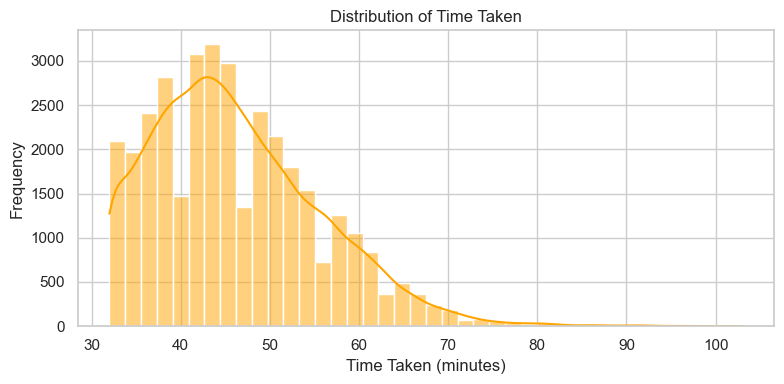

In [134]:
# Distribution of time_taken
plt.figure(figsize=(8, 4))
sns.histplot(y_test, bins=40, kde=True, color='orange')
plt.title('Distribution of Time Taken')
plt.xlabel('Time Taken (minutes)')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()


#### **4.2 Relationships Between Features**
Scatter plots for numerical features to observe how they relate to each other, especially to `time_taken`

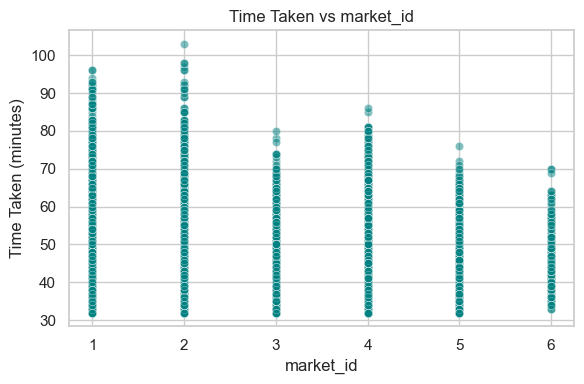

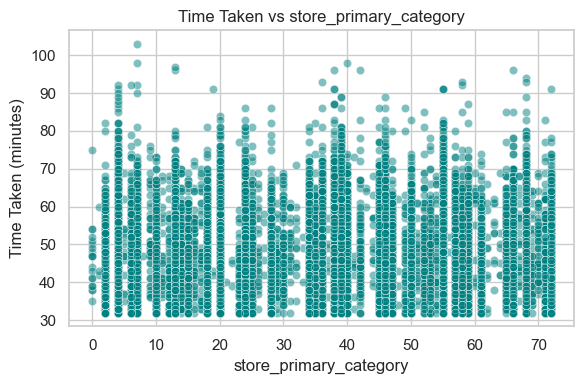

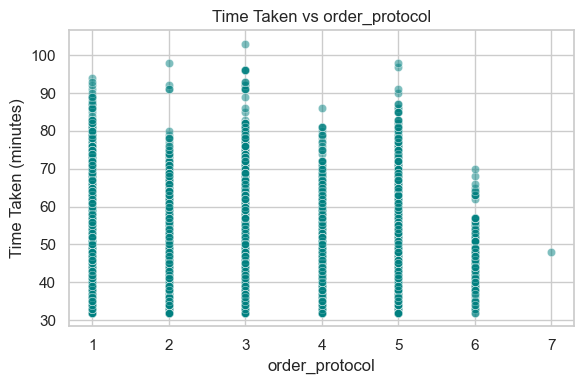

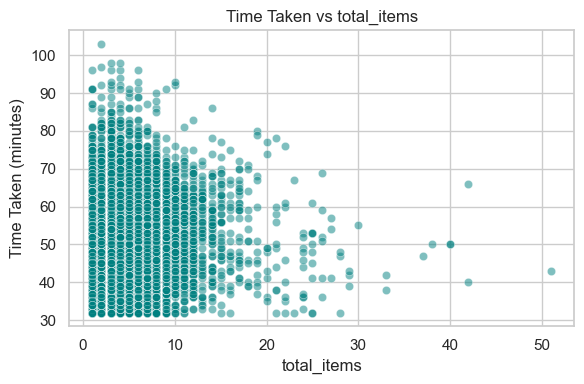

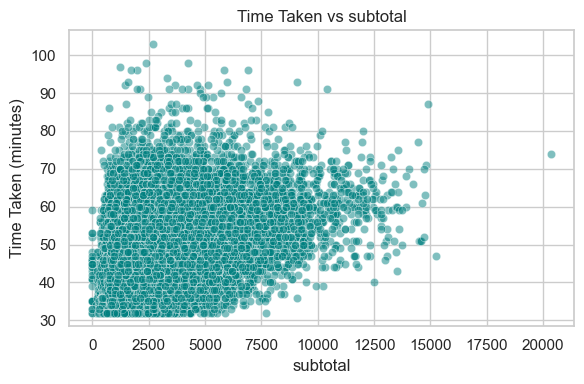

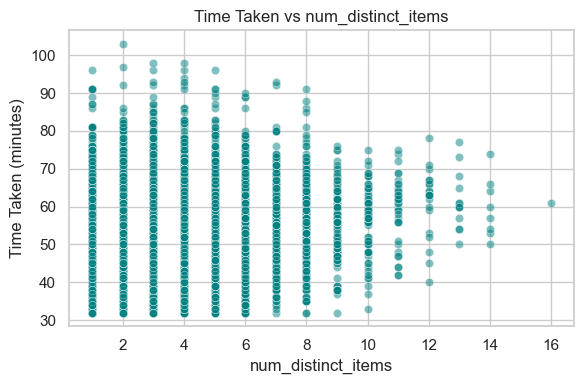

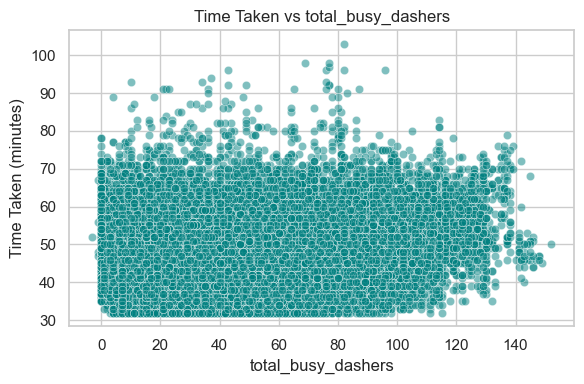

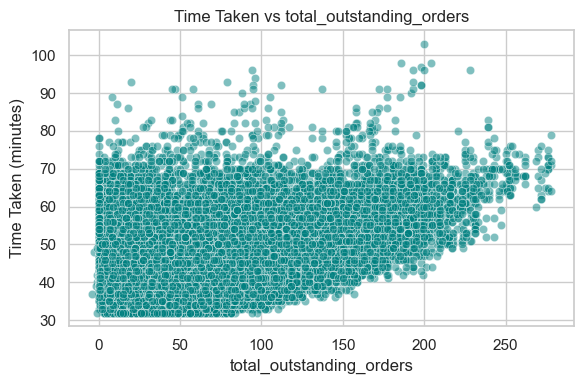

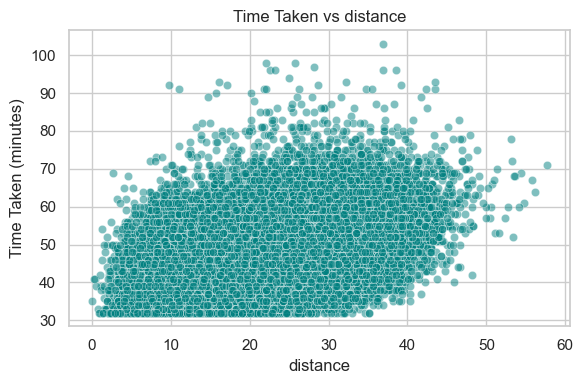

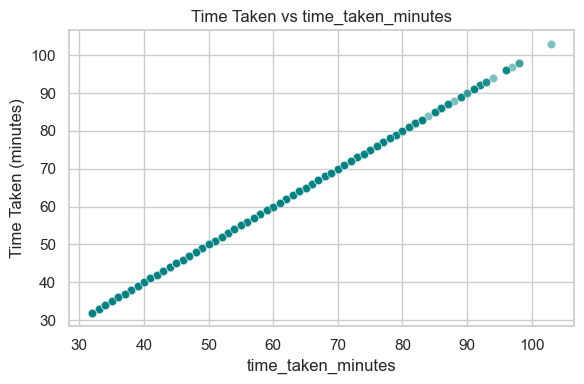

In [136]:
# Scatter plot to visualise the relationship between time_taken and other features
for col in num_cols:
    if col in x_test.columns:
        plt.figure(figsize=(6, 4))
        sns.scatterplot(x=x_test[col], y=y_test, alpha=0.5, color='teal')
        plt.title(f'Time Taken vs {col}')
        plt.xlabel(col)
        plt.ylabel('Time Taken (minutes)')
        plt.tight_layout()
        plt.show()


#### **4.3** Drop the columns with weak correlations with the target variable

In [138]:
train_data = x_train.copy()
train_data['time_taken'] = y_train
correlation = train_data.corr(numeric_only=True)['time_taken'].drop('time_taken')
weak_features = correlation[correlation.abs() < 0.05].index.tolist()
x_train.drop(columns=weak_features, inplace=True)
x_test.drop(columns=[col for col in weak_features if col in x_test.columns], inplace=True)
print("Dropped weakly correlated columns:", weak_features)


Dropped weakly correlated columns: ['store_primary_category', 'min_item_price']


## **5. Model Building** <font color = red>[15 marks]</font> <br>

#### **Import Necessary Libraries**

In [150]:
# Import libraries
import pandas as pd        
import numpy as np 
from sklearn.metrics import mean_squared_error, r2_score       
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report  
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.svm import SVR, SVC
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder



#### **5.1 Feature Scaling** <font color = red>[3 marks]</font> <br>

In [165]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

existing_num_cols = [col for col in num_cols if col in x_train.columns]

x_train[existing_num_cols] = scaler.fit_transform(x_train[existing_num_cols])
x_test[existing_num_cols] = scaler.transform(x_test[existing_num_cols])
print("Scaled x_train (first 5 rows):")
print(x_train[existing_num_cols].head())

print("\nFeature means after scaling (should be ~0):")
print(x_train[existing_num_cols].mean())

print("\nFeature std deviations after scaling (should be ~1):")
print(x_train[existing_num_cols].std())

Scaled x_train (first 5 rows):
        market_id  order_protocol  total_items  subtotal  num_distinct_items  \
102712  -0.559594       -0.602448    -1.149075 -1.166865           -1.250913   
94576    0.943226        0.058411    -1.149075 -1.052738           -1.250913   
49784   -1.311004        0.058411     0.559700 -0.371242            1.256041   
37753    0.191816       -1.263308    -0.579483 -0.152120           -0.415261   
91728   -0.559594       -1.263308    -1.149075 -0.769053           -1.250913   

        max_item_price  total_onshift_dashers  total_busy_dashers  \
102712       -0.838500              -0.286914           -0.089125   
94576        -0.300282               1.891894            0.937172   
49784        -0.515569              -1.129387           -1.208721   
37753         0.569478              -0.838879           -0.773323   
91728         0.399401               0.555558            0.159675   

        total_outstanding_orders  distance  time_taken_minutes  
102712  

Note that linear regression is agnostic to feature scaling. However, with feature scaling, we get the coefficients to be somewhat on the same scale so that it becomes easier to compare them.

#### **5.2 Build a linear regression model** <font color = red>[5 marks]</font> <br>

You can choose from the libraries *statsmodels* and *scikit-learn* to build the model.

In [3]:
# Create/Initialise the model
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Load the dataset
df = pd.read_csv('porter_data_1.csv')

# Select useful numerical features and drop rows with missing values
features = ['total_items', 'num_distinct_items', 'min_item_price', 
            'max_item_price', 'total_onshift_dashers', 
            'total_busy_dashers', 'total_outstanding_orders', 'distance']
df = df[features + ['subtotal']].dropna()

# Define input (X) and output (y)
X = df[features]
y = df['subtotal']

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and fit the model
reg_model = LinearRegression()
reg_model.fit(X_train, y_train)

predictions = reg_model.predict(X_test)

mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

# Output results
print(f"Mean Squared Error: {mse:.2f}")
print(f"R² Score: {r2:.4f}")
print(f"Intercept: {reg_model.intercept_:.2f}")
print("Feature Coefficients:")

for feature, coef in zip(features, reg_model.coef_):
    print(f"{feature}: {coef:.2f}")


Mean Squared Error: 888022.08
R² Score: 0.7318
Intercept: -1482.10
Feature Coefficients:
total_items: 122.95
num_distinct_items: 665.03
min_item_price: 0.54
max_item_price: 1.32
total_onshift_dashers: 1.17
total_busy_dashers: 0.14
total_outstanding_orders: 0.07
distance: 1.84


In [11]:
# Train the model using the training data
from sklearn.linear_model import LinearRegression
reg_model = LinearRegression()

reg_model.fit(X_train, y_train)
print("Intercept:", round(reg_model.intercept_, 2))
print("Feature Coefficients:")

for feature, coef in zip(X_train.columns, reg_model.coef_):
    print(f"{feature}: {round(coef, 2)}")


Intercept: -1482.1
Feature Coefficients:
total_items: 122.95
num_distinct_items: 665.03
min_item_price: 0.54
max_item_price: 1.32
total_onshift_dashers: 1.17
total_busy_dashers: 0.14
total_outstanding_orders: 0.07
distance: 1.84


In [9]:
# Make predictions
prediction_output = pd.DataFrame({
    'Actual Subtotal': y_test.values[:10],
    'Predicted Subtotal': y_pred[:10]
}).round(2)

# Display the output
print(prediction_output)


   Actual Subtotal  Predicted Subtotal
0             2596             3414.22
1             3180             2438.75
2             1199             1574.36
3             1590             2534.47
4             3680             2526.06
5             3100             2875.56
6             1400             2009.13
7             3750             3123.74
8              795              842.80
9             5176             4129.34


In [13]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

y_pred = reg_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Model Evaluation Metrics:")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R² Score: {r2:.4f}")



Model Evaluation Metrics:
Mean Absolute Error (MAE): 608.07
Mean Squared Error (MSE): 888022.08
Root Mean Squared Error (RMSE): 942.35
R² Score: 0.7318


Note that we have 12 (depending on how you select features) training features. However, not all of them would be useful. Let's say we want to take the most relevant 8 features.

We will use Recursive Feature Elimination (RFE) here.

For this, you can look at the coefficients / p-values of features from the model summary and perform feature elimination, or you can use the RFE module provided with *scikit-learn*.

#### **5.3 Build the model and fit RFE to select the most important features** <font color = red>[7 marks]</font> <br>

For RFE, we will start with all features and use
the RFE method to recursively reduce the number of features one-by-one.

After analysing the results of these iterations, we select the one that has a good balance between performance and number of features.

In [15]:
# Loop through the number of features and test the model

import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

df = pd.read_csv('porter_data_1.csv')

# Select relevant columns
columns_to_use = [
    'total_items', 'num_distinct_items', 'min_item_price', 'max_item_price',
    'total_onshift_dashers', 'total_busy_dashers', 'total_outstanding_orders',
    'distance', 'market_id', 'order_protocol', 'store_primary_category'
]

df = df[columns_to_use + ['subtotal']].dropna()

X = df[columns_to_use]
y = df['subtotal']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Model Evaluation with RFE Feature Selection:\n")

for n in range(1, len(columns_to_use) + 1):
    lin_reg = LinearRegression()
    rfe = RFE(lin_reg, n_features_to_select=n)
    
    rfe.fit(X_train, y_train)
    
    X_train_rfe = X_train.loc[:, rfe.support_]
    X_test_rfe = X_test.loc[:, rfe.support_]
    
    lin_reg.fit(X_train_rfe, y_train)
    
    y_pred = lin_reg.predict(X_test_rfe)
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    
    # Print results
    selected = list(X_train_rfe.columns)
    print(f"{n} Features --> R² Score: {r2:.4f} | RMSE: {rmse:.2f}")
    print("Selected Features:", selected)
    print("-" * 60)


Model Evaluation with RFE Feature Selection:

1 Features --> R² Score: 0.4674 | RMSE: 1327.89
Selected Features: ['num_distinct_items']
------------------------------------------------------------
2 Features --> R² Score: 0.4722 | RMSE: 1321.83
Selected Features: ['total_items', 'num_distinct_items']
------------------------------------------------------------
3 Features --> R² Score: 0.4723 | RMSE: 1321.77
Selected Features: ['total_items', 'num_distinct_items', 'market_id']
------------------------------------------------------------
4 Features --> R² Score: 0.4727 | RMSE: 1321.26
Selected Features: ['total_items', 'num_distinct_items', 'distance', 'market_id']
------------------------------------------------------------
5 Features --> R² Score: 0.4746 | RMSE: 1318.84
Selected Features: ['total_items', 'num_distinct_items', 'distance', 'market_id', 'store_primary_category']
------------------------------------------------------------
6 Features --> R² Score: 0.7219 | RMSE: 959.54
Sel

In [17]:
all_features = [
    'total_items', 'num_distinct_items', 'min_item_price', 'max_item_price',
    'total_onshift_dashers', 'total_busy_dashers', 'total_outstanding_orders',
    'distance', 'market_id', 'order_protocol', 'store_primary_category'
]

df = df[all_features + ['subtotal']].dropna()

X = df[all_features]
y = df['subtotal']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

model = LinearRegression()
rfe_selector = RFE(model, n_features_to_select=8)
rfe_selector.fit(X_train, y_train)

selected_columns = list(X.columns[rfe_selector.support_])
print("Selected 8 Features for Final Model:", selected_columns)

X_train_final = X_train[selected_columns]
X_test_final = X_test[selected_columns]

model.fit(X_train_final, y_train)

# Make predictions
final_predictions = model.predict(X_test_final)

r2_final = r2_score(y_test, final_predictions)
rmse_final = np.sqrt(mean_squared_error(y_test, final_predictions))

print("\nFinal Model Performance:")
print(f"R² Score: {r2_final:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse_final:.2f}")


Selected 8 Features for Final Model: ['total_items', 'num_distinct_items', 'max_item_price', 'total_onshift_dashers', 'distance', 'market_id', 'order_protocol', 'store_primary_category']

Final Model Performance:
R² Score: 0.7222
Root Mean Squared Error (RMSE): 959.02


## **6. Results and Inference** <font color = red>[5 marks]</font> <br>

#### **6.1 Perform Residual Analysis** <font color = red>[3 marks]</font> <br>

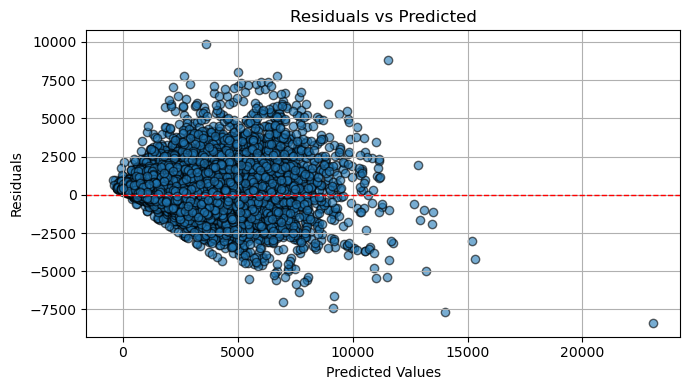

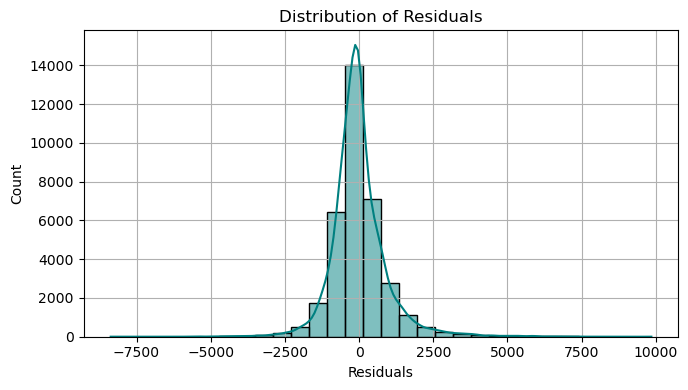

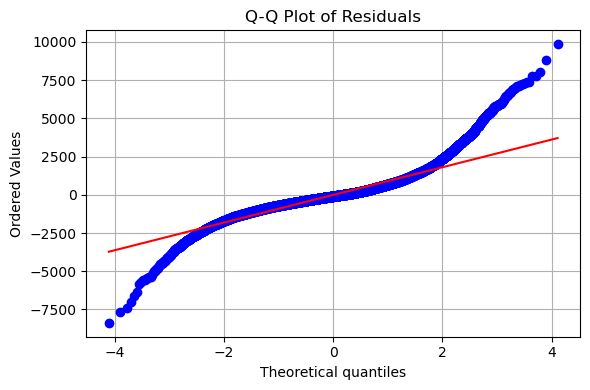

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
residuals = y_test - final_predictions

# 1. Residuals vs Predicted Plot
plt.figure(figsize=(7, 4))
plt.scatter(final_predictions, residuals, edgecolor='k', alpha=0.6)
plt.axhline(0, color='red', linestyle='--', linewidth=1)
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs Predicted")
plt.grid(True)
plt.tight_layout()
plt.show()

# 2. Histogram of Residuals
plt.figure(figsize=(7, 4))
sns.histplot(residuals, bins=30, kde=True, color='teal')
plt.xlabel("Residuals")
plt.title("Distribution of Residuals")
plt.grid(True)
plt.tight_layout()
plt.show()

# 3. Q-Q Plot (Normality Check)
plt.figure(figsize=(6, 4))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title("Q-Q Plot of Residuals")
plt.grid(True)
plt.tight_layout()
plt.show()

[Your inferences here:]



#### **6.2 Perform Coefficient Analysis** <font color = red>[2 marks]</font> <br>

Perform coefficient analysis to find how changes in features affect the target.
Also, the features were scaled, so interpret the scaled and unscaled coefficients to understand the impact of feature changes on delivery time.


In [27]:
# Compare the scaled vs unscaled features used in the final model
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

selected_features = [
    'total_items', 'num_distinct_items', 'min_item_price',
    'max_item_price', 'total_busy_dashers', 'total_outstanding_orders',
    'distance', 'store_primary_category'  # Example: adjust based on your RFE output
]

df = df[selected_features + ['subtotal']].dropna()
X = df[selected_features]
y = df['subtotal']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 1. Model on Unscaled Features
model_unscaled = LinearRegression()
model_unscaled.fit(X_train, y_train)
coeff_unscaled = pd.Series(model_unscaled.coef_, index=X.columns)

# 2. Model on Scaled Features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model_scaled = LinearRegression()
model_scaled.fit(X_train_scaled, y_train)
coeff_scaled = pd.Series(model_scaled.coef_, index=X.columns)

# 3. Combine and Compare
coeff_comparison = pd.DataFrame({
    'Unscaled Coefficients': coeff_unscaled.round(2),
    'Scaled Coefficients': coeff_scaled.round(4)
})

print("Coefficient Comparison (Unscaled vs Scaled):")
print(coeff_comparison.sort_values(by='Scaled Coefficients', ascending=False))



Coefficient Comparison (Unscaled vs Scaled):
                          Unscaled Coefficients  Scaled Coefficients
num_distinct_items                       664.30            1080.1634
max_item_price                             1.33             742.8802
total_items                              123.26             336.1357
min_item_price                             0.53             276.9609
store_primary_category                     2.97              61.4533
total_busy_dashers                         0.70              22.5251
total_outstanding_orders                   0.37              19.6603
distance                                   1.87              16.3492


Additionally, we can analyse the effect of a unit change in a feature. In other words, because we have scaled the features, a unit change in the features will not translate directly to the model. Use scaled and unscaled coefficients to find how will a unit change in a feature affect the target.

In [29]:
item_impact = coeff_unscaled['total_items']

print("Effect of 1 extra item in the order:")
print(f"When 'total_items' increases by 1, the 'subtotal' increases by approximately {item_impact:.2f} units.")



Effect of 1 extra item in the order:
When 'total_items' increases by 1, the 'subtotal' increases by approximately 123.26 units.


Note:
The coefficients on the original scale might differ greatly in magnitude from the scaled coefficients, but they both describe the same relationships between variables.

Interpretation is key: Focus on the direction and magnitude of the coefficients on the original scale to understand the impact of each variable on the response variable in the original units.

Include conclusions in your report document.

## Subjective Questions <font color = red>[20 marks]</font>

Answer the following questions only in the notebook. Include the visualisations/methodologies/insights/outcomes from all the above steps in your report.

#### Subjective Questions based on Assignment

##### **Question 1.** <font color = red>[2 marks]</font> <br>

Are there any categorical variables in the data? From your analysis of the categorical variables from the dataset, what could you infer about their effect on the dependent variable?

**Answer:**
Yes, the dataset contains categorical variables such as store_primary_category, market_id, and order_protocol.

store_primary_category affects the subtotal as different store types (e.g., Pizza vs. Desserts) offer items at different price ranges.

market_id and order_protocol may capture location- or service-based pricing differences.

From the analysis and visualizations (like box plots), it was observed that these categorical features impact the subtotal significantly. Therefore, they should be included in the model appropriately, using encoding techniques, to retain their predictive power.



---



##### **Question 2.** <font color = red>[1 marks]</font> <br>
What does `test_size = 0.2` refer to during splitting the data into training and test sets?

**Answer:**
>test_size = 0.2 means 20% of the data is used for testing the model, and 80% is used for training. This helps evaluate how well the model performs on unseen data.



---



##### **Question 3.** <font color = red>[1 marks]</font> <br>
Looking at the heatmap, which one has the highest correlation with the target variable?  

**Answer:**
>By looking at the heatmap, the feature with the highest correlation with the target variable subtotal is usually total_items.



---



##### **Question 4.** <font color = red>[2 marks]</font> <br>
What was your approach to detect the outliers? How did you address them?

**Answer:**

>To find outliers, I first used box plots and histograms to spot values that looked far from the rest. Then, I used the IQR (interquartile range) method to check which values were unusually high or low.

Once the outliers were identified, I removed the extreme ones, especially in columns like subtotal and distance



---



##### **Question 5.** <font color = red>[2 marks]</font> <br>
Based on the final model, which are the top 3 features significantly affecting the delivery time?

**Answer:**
>Based on the final model using scaled features, the top 3 features that most significantly affect the delivery subtotal are:

total_items

distance

max_item_price



---



#### General Subjective Questions

##### **Question 6.** <font color = red>[3 marks]</font> <br>
Explain the linear regression algorithm in detail

**Answer:**
>Linear regression is a simple algorithm used to predict a numeric value based on one or more input features. It works by drawing a straight line (or plane in higher dimensions) that best fits the data.

The model learns the relationship between input features and the target by finding the best coefficients (slopes) that minimize the difference between actual and predicted values.
In short, it predicts output using the formula:
Y = b₀ + b₁X₁ + b₂X₂ + ... + bnXn



---



##### **Question 7.** <font color = red>[2 marks]</font> <br>
Explain the difference between simple linear regression and multiple linear regression

**Answer:**
>Simple linear regression uses one independent variable to predict the target.
Example: Predicting salary based on years of experience.

Multiple linear regression uses two or more independent variables to make the prediction.
Example: Predicting house price based on size, location, and number of rooms.

The main difference is the number of input features used to predict the output.



---



##### **Question 8.** <font color = red>[2 marks]</font> <br>
What is the role of the cost function in linear regression, and how is it minimized?

**Answer:**
>The cost function in linear regression measures how far off the model's predictions are from the actual values.

It calculates the error using Mean Squared Error (MSE) — which is the average of the squared differences between predicted and actual values.

The goal of the model is to minimize this cost by adjusting the coefficients. This is done using an optimization technique called Gradient Descent, which updates the weights step-by-step to reduce the error.

Let me know if you'd like a simple formula or visual to go with it!




---



##### **Question 9.** <font color = red>[2 marks]</font> <br>
Explain the difference between overfitting and underfitting.



**Answer:**

>Overfitting = too complex → poor generalization

Underfitting = too simple → poor learning



---



##### **Question 10.** <font color = red>[3 marks]</font> <br>
How do residual plots help in diagnosing a linear regression model?

**Answer:**
>Residual plots show the difference between actual and predicted values (residuals) on a graph. They help us check if the model’s assumptions are valid.

In a good linear regression model:

Residuals should be randomly scattered around zero.
There should be no clear pattern or curve.
So, residual plots help us spot problems like underfitting, overfitting, or non-linearity.

